# Data Science 207 - Introduction to Machine Learning
## Final Project for Team 4 / Section 4 / Fall 2023

__Team Members__
- Arias, Nathan (ihsiukao@berkeley.edu)
- Houghton, Douglas (ihsiukao@berkeley.edu)
- Kao, I-Hsiu (ihsiukao@berkeley.edu)

__Project Repo__

https://github.com/dchoughton/207_final_project

# Explatory Data Analysis (EDA)

## 1. Dataset Background

The dataset selected is the ___Skin Cancer MNIST: HAM10000___ hosted on Kaggle (https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000) and the Harvard Dataverse (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

This dataset includes 10015 images and precomputed RGB values for a variety of skin cancer lesions.

### Kaggle Dataset Description
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

***
When using the ISIC 2018 datasets in your research, please cite the following works:

[1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: "Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)", 2018; https://arxiv.org/abs/1902.03368

[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

### 2. Load Packages and Data

In [1]:
# Standard Data Packages
import pandas as pd
import numpy as np

# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Modelling
import tensorflow as tf
from tensorflow import keras
from keras import metrics

In [2]:
# Prevent multiple instances of OpenMP from crashing kernel on Windows.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Set seed for use throughout.
set_seed = 2070404

# Load data files.
metadata = pd.read_csv('HAM10000_metadata.csv')
rgb_data = pd.read_csv('hmnist_28_28_RGB.csv')

### 3. Samples and Features

Per the Kaggle description, the data set is expected to included 10015 samples split into the two files.

In [4]:
metadata.shape

(10015, 7)

In [5]:
rgb_data.shape

(10015, 2353)

The metadata file is expected to have ancillary informaiton regarding the patient as well as identify images by name for each record.

In [6]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


The RGB file is expected to have the per pixel RGB value for the 28x28 sized images across each the of the RGB channels (totalling 2352 values per image). Addtionally, these records are expected to include the label data for each image.

In [7]:
rgb_data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [8]:
# Label coding key.
label_codes = {
                0: {'short':'AKIEC', 'full':'Actinic Keratoses and Intraepithelial Carcinoma / Bowens disease'},
                1: {'short':'BCC', 'full':'Basal Cell Carcinoma'},
                2: {'short':'BKL', 'full':'Benign Keratosis-like Lesions'},
                3: {'short':'DF', 'full':'Dermatofibroma'},
                4: {'short':'NV', 'full':'Melanocytic Nevi'},
                5: {'short':'VASC', 'full':'Vascular Lesions'},
                6: {'short':'MEL', 'full':'Melanoma'}
              }

label_simple = ['AKIEC', 'BCC', 'BKL', 'DF', 'NV', 'VASC', 'MEL']

In [9]:
# Record count by label.
rgb_data.groupby(by='label').size()

label
0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
dtype: int64

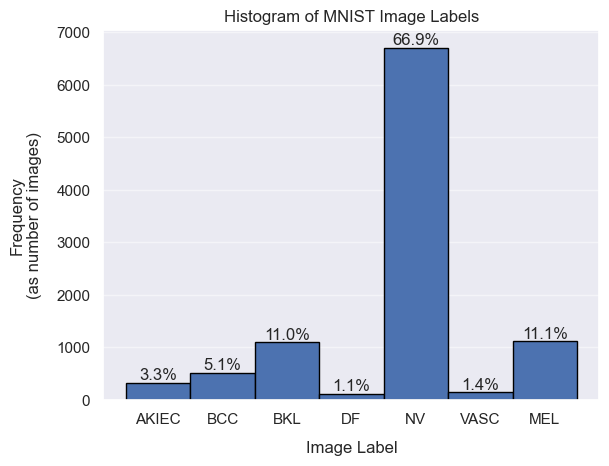

In [10]:
# Record count visualization.
# Build histogram of diagnosis class value counts.
fig = rgb_data.label.hist(grid=False, bins=np.arange(8)-0.5, edgecolor='black', zorder=2.5)

# Update presentation and format.
fig.set_ylabel('Frequency\n(as number of images)', labelpad=10)
fig.set_xlabel('Image Label', labelpad=10)
fig.set_title("Histogram of MNIST Image Labels")

chart_ticks, chart_labels = [], []
for code, description in label_codes.items():
    chart_ticks.append(code)
    chart_labels.append(description['short'])
                        
fig.set_xticks(chart_ticks, chart_labels)
fig.grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# Add percentage calculation and labels.
for i in chart_ticks:
    count = len(rgb_data.label[rgb_data.label==i])
    fig.text(x=i, y=count+50, s=f"{round(count/len(rgb_data) * 100,1)}%", horizontalalignment='center')

__NOTE__ Large imbalance in labels that will have to be corrected.

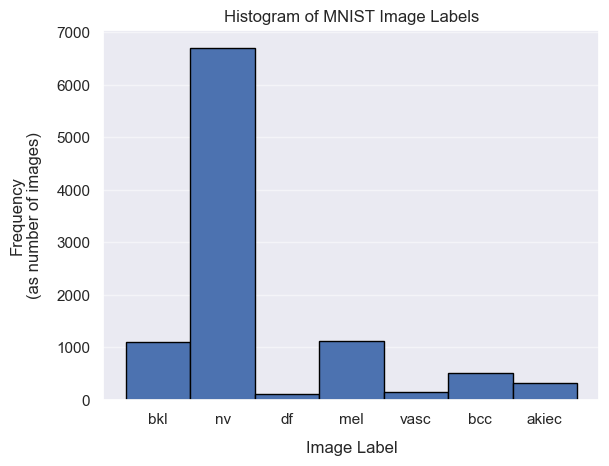

In [11]:
# Confirm metadata diagnosis (dx) distribution matches RGB file label distribution.
# Build histogram of diagnosis class value counts.
fig = metadata.dx.hist(grid=False, bins=np.arange(8)-0.5, edgecolor='black', zorder=2.5)

# Update presentation and format.
fig.set_ylabel('Frequency\n(as number of images)', labelpad=10)
fig.set_xlabel('Image Label', labelpad=10)
fig.set_title("Histogram of MNIST Image Labels")

fig.grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

In [12]:
# Count combinations of dx and dx_type for plot.
temp_df_1 = pd.concat([metadata.dx, metadata.dx_type], axis=1)
dx_by_type = pd.DataFrame(temp_df_1.groupby(['dx', 'dx_type']).size()).reset_index().rename(columns={0:'num_count'})
dx_by_type = dx_by_type.astype({'num_count':'int'})

# Count combinations of dx and localization for plot.
temp_df_2 = pd.concat([metadata.dx, metadata.localization], axis=1)
dx_by_local = pd.DataFrame(temp_df_2.groupby(['dx', 'localization']).size()).reset_index().rename(columns={0:'num_count'})
dx_by_local = dx_by_local.astype({'num_count':'int'})

display(dx_by_type.head())
display(dx_by_local.head())

,dx,dx_type,num_count
0,akiec,histo,327
1,bcc,histo,514
2,bkl,confocal,69
3,bkl,consensus,264
4,bkl,histo,766


,dx,localization,num_count
0,akiec,abdomen,5
1,akiec,back,29
2,akiec,chest,12
3,akiec,ear,3
4,akiec,face,113


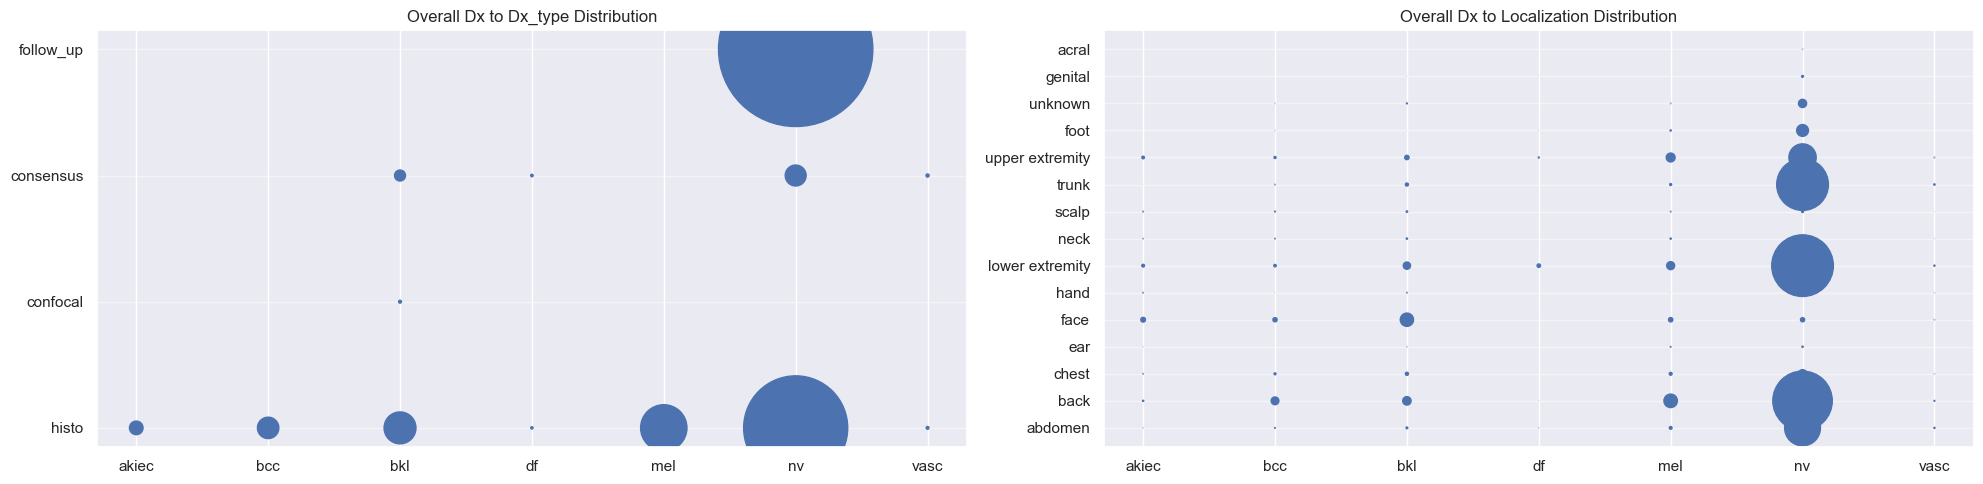

In [13]:
# Review diagnosis distribution method.
chart_ticks, chart_labels = [], []

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# Overall Dx to dx method distribution.
size_1 = (0.03 * dx_by_type.num_count) ** 2
axes[0].scatter(x=dx_by_type.dx, y=dx_by_type.dx_type, s=size_1)

axes[0].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)
axes[0].set_title('Overall Dx to Dx_type Distribution')

size = (0.03 * dx_by_local.num_count) ** 2
axes[1].scatter(x=dx_by_local.dx, y=dx_by_local.localization, s=size)

axes[1].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)
axes[1].set_title('Overall Dx to Localization Distribution')

fig.tight_layout()
plt.show()

### 3. Merge, Shuffle, and Split

In [14]:
# Merge metadata and rgb values.
rgb_merge = pd.concat([metadata, rgb_data], axis=1, join="inner")
rgb_merge.shape

(10015, 2360)

In [15]:
rgb_merge.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,192,153,193,...,173,124,138,183,147,166,185,154,177,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,25,14,30,...,60,39,55,25,14,28,25,14,27,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,192,138,153,...,167,129,143,159,124,142,136,104,117,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,38,19,30,...,44,26,36,25,12,17,25,12,15,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,158,113,139,...,209,166,185,172,135,149,109,78,92,2


In [16]:
# Drop all metadata NA values.
rgb_merge = rgb_merge.dropna()
display(rgb_merge.shape)

rgb_merge.head()

(9958, 2360)

,lesion_id,image_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,192,153,193,...,173,124,138,183,147,166,185,154,177,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,25,14,30,...,60,39,55,25,14,28,25,14,27,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,192,138,153,...,167,129,143,159,124,142,136,104,117,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,38,19,30,...,44,26,36,25,12,17,25,12,15,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,158,113,139,...,209,166,185,172,135,149,109,78,92,2


In [17]:
# Create data splits.

# Split into train, validation, and test.
np.random.seed(set_seed)

# Shuffle all records.
rgb_shuffle = rgb_merge.sample(frac = 1)

# Create split counts.
splits = np.multiply(len(rgb_shuffle), (0.6,0.2,0.2)).astype(int)
print(f"Split counts (train/ validation/ test): {splits}")

# Create split data sets.
rgb_train, rgb_valid, rgb_test = np.split(rgb_shuffle, [splits[0], splits[0]+splits[1]])

# Reset split set indicies.
rgb_train.reset_index(drop=True, inplace=True)
rgb_valid.reset_index(drop=True, inplace=True)
rgb_test.reset_index(drop=True, inplace=True)

Split counts (train/ validation/ test): [5974 1991 1991]


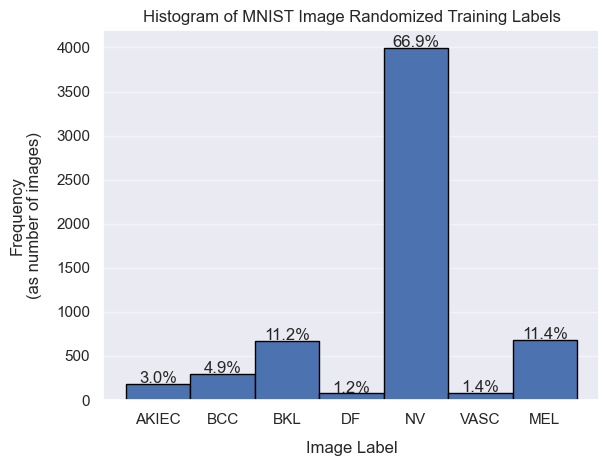

In [18]:
# Training record count visualization.
# Build histogram of diagnosis class value counts.
fig = rgb_train.label.hist(grid=False, bins=np.arange(8)-0.5, edgecolor='black', zorder=2.5)

# Update presentation and format.
fig.set_ylabel('Frequency\n(as number of images)', labelpad=10)
fig.set_xlabel('Image Label', labelpad=10)
fig.set_title("Histogram of MNIST Image Randomized Training Labels")

chart_ticks, chart_labels = [], []
for code, description in label_codes.items():
    chart_ticks.append(code)
    chart_labels.append(description['short'])
                        
fig.set_xticks(chart_ticks, chart_labels)
fig.grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# Add percentage calculation and labels.
for i in chart_ticks:
    count = len(rgb_train.label[rgb_train.label==i])
    fig.text(x=i, y=count+10, s=f"{round(count/len(rgb_train) * 100,1)}%", horizontalalignment='center')

In [19]:
# Validate sizes.
print(f"Training data shape: {rgb_train.shape}")
print(f"Validation data shape: {rgb_valid.shape}")
print(f"Testing data shape: {rgb_test.shape}")

Training data shape: (5974, 2360)
Validation data shape: (1991, 2360)
Testing data shape: (1993, 2360)


In [20]:
rgb_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,HAM_0003483,ISIC_0025501,nv,follow_up,45.0,female,lower extremity,210,118,133,...,196,116,132,186,100,118,181,90,110,4
1,HAM_0003878,ISIC_0031072,nv,follow_up,30.0,female,foot,247,176,190,...,240,180,187,238,180,186,237,181,186,4
2,HAM_0002613,ISIC_0024958,mel,histo,45.0,male,lower extremity,163,133,135,...,197,159,153,196,156,151,195,162,159,6
3,HAM_0006126,ISIC_0027715,nv,histo,40.0,male,upper extremity,220,147,159,...,232,171,173,232,170,168,230,169,168,4
4,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,197,156,162,...,205,162,173,203,158,164,204,162,168,3


In [21]:
# Split data and image RGB values.
rgb_train_images = np.array(rgb_train.filter(like='pixel'), dtype=np.uint8).reshape(-1,28,28,3)

data_cols = ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'label']
rgb_train_data = rgb_train.filter(items=data_cols)

### 4. Additional EDA on Training Data

In [22]:
display(rgb_train_images.shape)
display(rgb_train_data.shape)

(5974, 28, 28, 3)

(5974, 8)

In [23]:
# Capture raw RBG spread.
rgb_value_count = pd.DataFrame(rgb_train.loc[:, 'pixel0000':'pixel2351'].apply(pd.value_counts).fillna(0).astype(int).sum(axis='columns'))

In [24]:
# Count combinations of dx and localization for plot.
temp_df_1 = pd.concat([rgb_train.dx, rgb_train.localization], axis=1)
rgb_dx_local = pd.DataFrame(temp_df_1.groupby(['dx', 'localization']).size()).reset_index().rename(columns={0:'num_count'})
rgb_dx_local = rgb_dx_local.astype({'num_count':'int'})

rgb_dx_local.head()

,dx,localization,num_count
0,akiec,abdomen,3
1,akiec,back,16
2,akiec,chest,6
3,akiec,ear,1
4,akiec,face,68


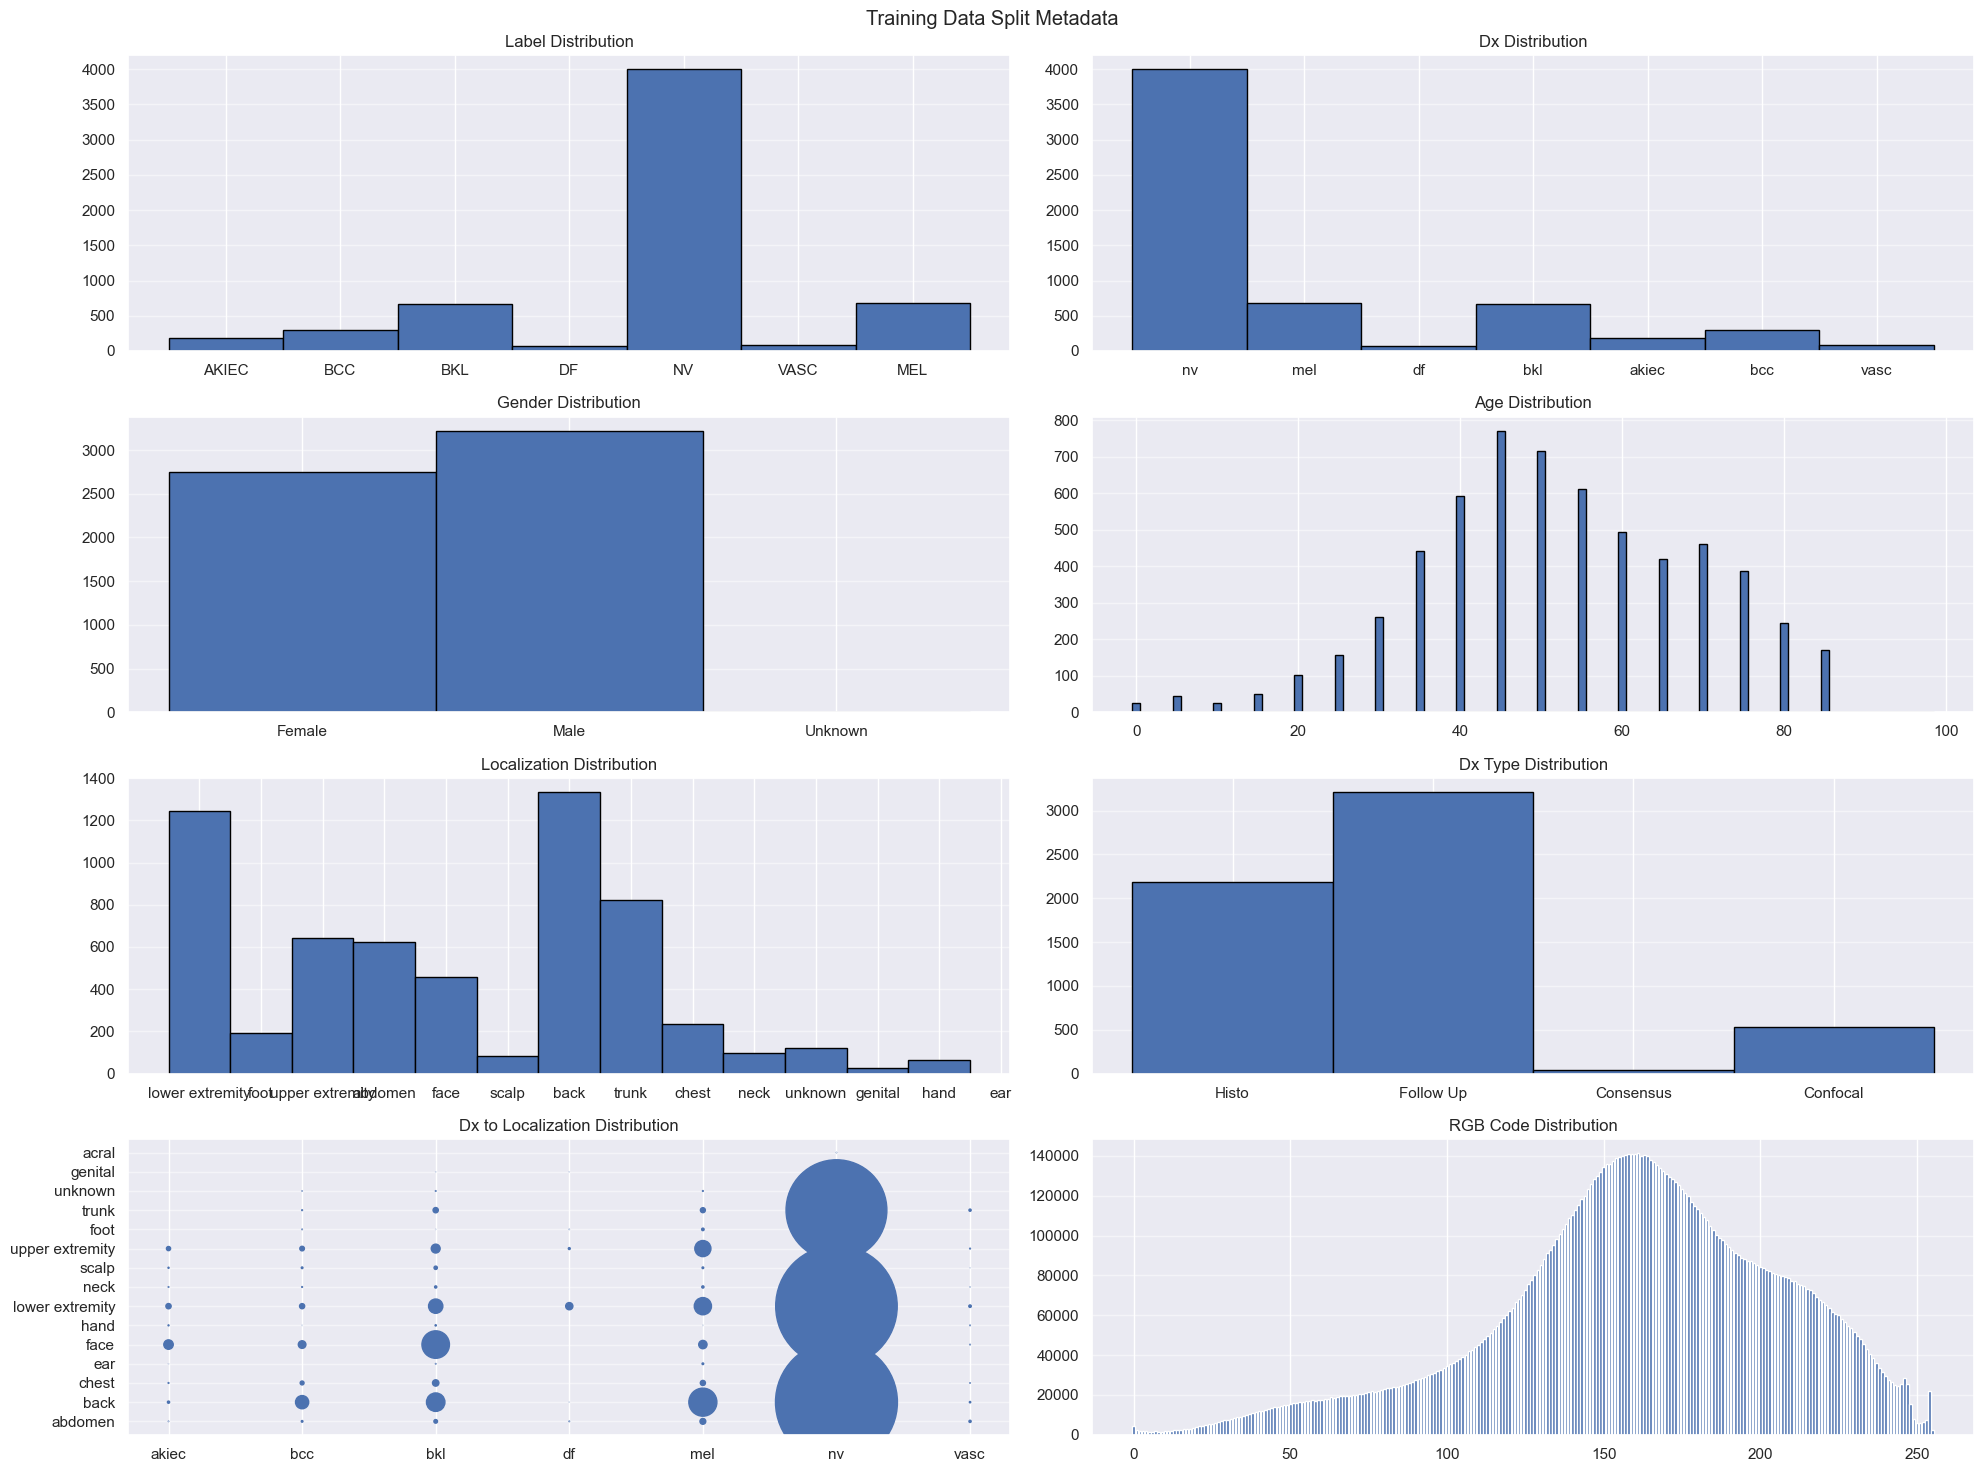

In [25]:
# Metadata count visualizations.

# Build histogram of diagnosis class value counts.
chart_ticks, chart_labels = [], []

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,15))
fig.suptitle('Training Data Split Metadata')

# Label distribution
axes[0,0].hist(x=rgb_train.label, bins=np.arange(8)-0.5, edgecolor='black', zorder=2.5)
axes[0,0].set_title('Label Distribution')

for code, description in label_codes.items():
    chart_ticks.append(code)
    chart_labels.append(description['short'])

axes[0,0].set_xticks(chart_ticks, chart_labels)
axes[0,0].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# Dx (diagnosis) Distribution - should match labels.
axes[0,1].hist(x=rgb_train.dx, bins=np.arange(8)-0.5, edgecolor='black', zorder=2.5)
axes[0,1].set_title('Dx Distribution')

axes[0,1].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# Gender Disribution
axes[1,0].hist(x=rgb_train.sex, bins=np.arange(4)-0.5, edgecolor='black', zorder=2.5)
axes[1,0].set_title('Gender Distribution')

chart_ticks = [0, 1, 2]
chart_labels = ['Female', 'Male', 'Unknown']

axes[1,0].set_xticks(chart_ticks, chart_labels)
axes[1,0].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# Age Distribution
axes[1,1].hist(x=rgb_train.age, bins=np.arange(100)-0.5, edgecolor='black', zorder=2.5)
axes[1,1].set_title('Age Distribution')

axes[1,1].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# Localization Disribution
axes[2,0].hist(x=rgb_train.localization, bins=np.arange(14)-0.5, edgecolor='black', zorder=2.5)
axes[2,0].set_title('Localization Distribution')

axes[2,0].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# Diagnosis Type Disribution
axes[2,1].hist(x=rgb_train.dx_type, bins=np.arange(5)-0.5, edgecolor='black', zorder=2.5)
axes[2,1].set_title('Dx Type Distribution')

chart_ticks = [0, 1, 2, 3]
chart_labels = ['Histo', 'Follow Up', 'Consensus', 'Confocal']

axes[2,1].set_xticks(chart_ticks, chart_labels)
axes[2,1].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)

# RGB Value distribution - should be 0 to 255 only.
size = (0.1 * rgb_dx_local.num_count) ** 2
axes[3,0].scatter(x=rgb_dx_local.dx, y=rgb_dx_local.localization, s=size)

axes[3,0].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)
axes[3,0].set_title('Dx to Localization Distribution')

# RGB Value distribution - should be 0 to 255 only.
axes[3,1].bar(x=rgb_value_count.index.tolist(), height=rgb_value_count.iloc[:, 0].tolist())

axes[3,1].grid(axis='y', visible=True, alpha=0.5, zorder=2.6)
axes[3,1].set_title('RGB Code Distribution')

fig.tight_layout()
plt.show()

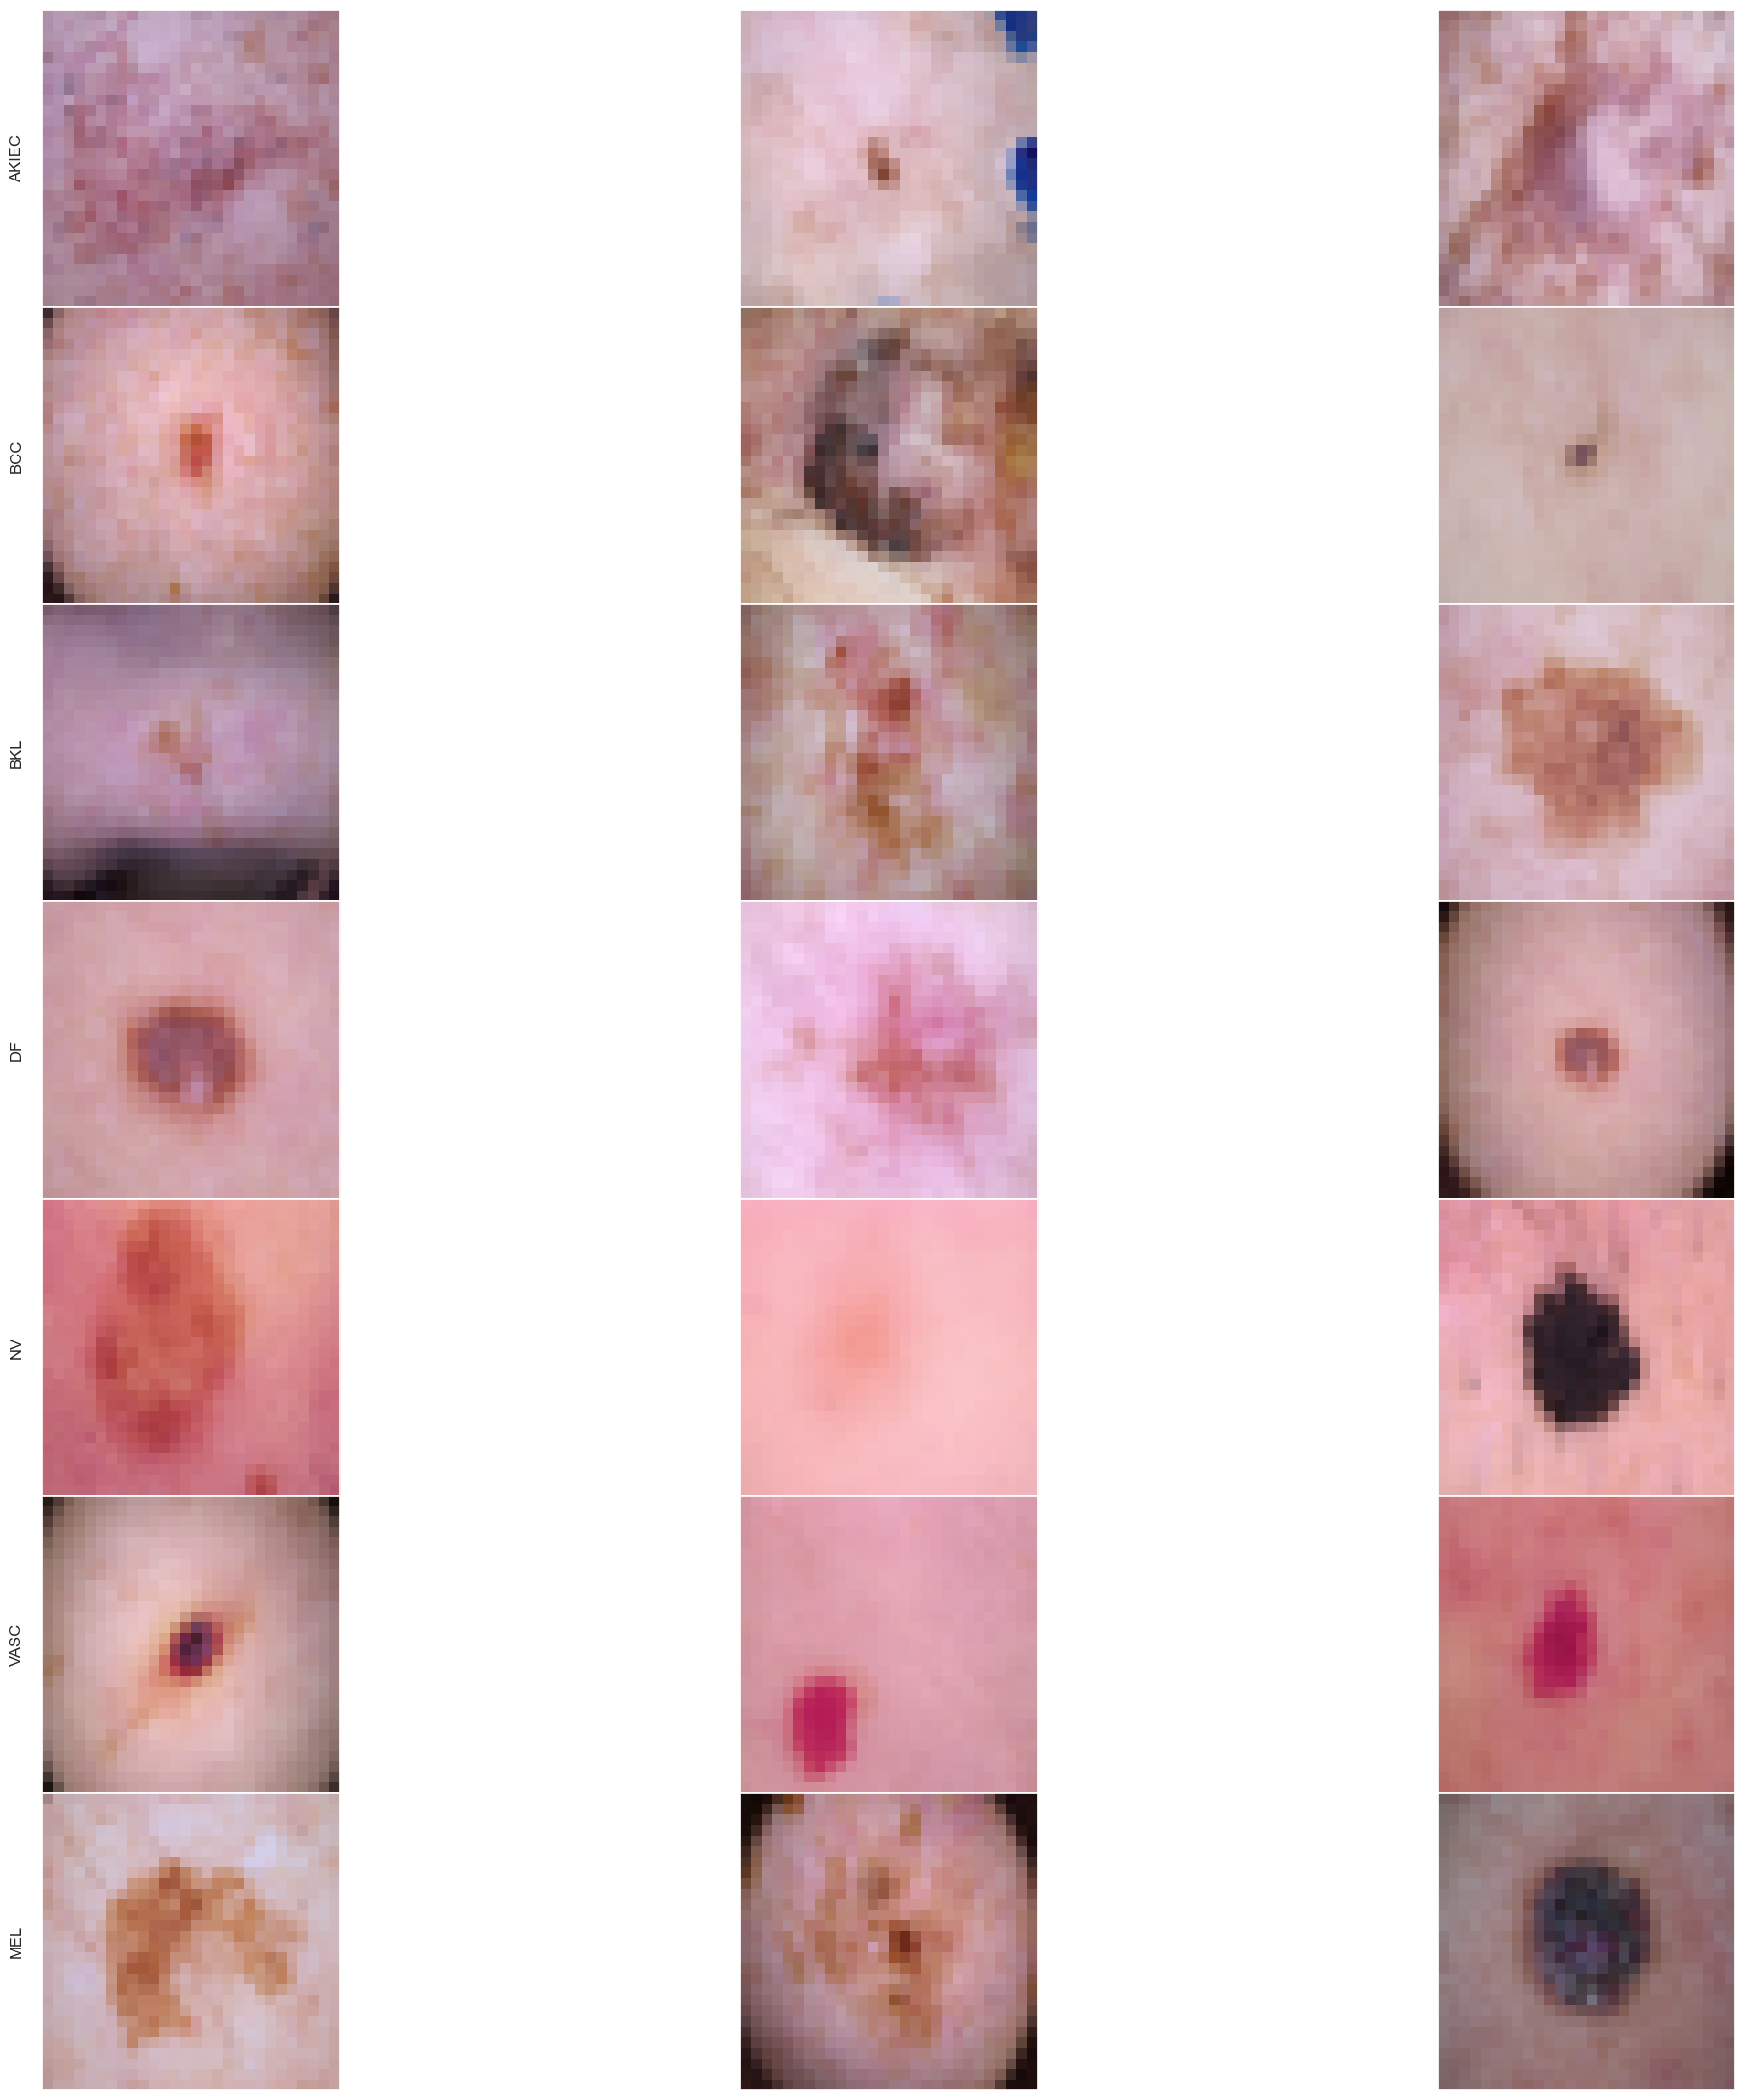

In [26]:
# Display sample RGB plots.

# Build figure and basic formatting.
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(28,28))

# Loop through all seven lesion variations.
for label_id in range(7):

    # Reset loop control variables and plot location.
    loop_found, loop_index = 0, 0
    label = label_codes[label_id]['short']

    # Loop through rows to find first five with matching labels.
    while loop_found < 3:
        
        # If the record is the type we want.
        if rgb_train_data.iloc[loop_index]['label'] == label_id:

            # Plot the matching image.
            axs[label_id, loop_found].imshow(rgb_train_images[loop_index])

            # Format subplot labels for clean output.
            axs[label_id, loop_found].grid(False)
            axs[label_id, loop_found].set_xticklabels([])
            axs[label_id, loop_found].set_yticklabels([])

            # Increment loop control for matching image count.
            loop_found += 1

        # Move loop to next Y_train record.
        loop_index += 1

    # Format complete axs, set plot labels and hide grid.
    axs[label_id,0].set_ylabel(label)

# Adjust image spacing and render Plot.
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()